In [212]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import pickle
import joblib

In [136]:
df=pd.read_csv('cars_dataset.csv')
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,Make
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi


# Data Exploration

In [137]:
df.shape

(72435, 10)

In [138]:
df.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
Make            0
dtype: int64

In [139]:
df.duplicated().sum()

842

In [140]:
df.drop_duplicates(inplace=True)

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71593 entries, 0 to 72434
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         71593 non-null  object 
 1   year          71593 non-null  int64  
 2   price         71593 non-null  int64  
 3   transmission  71593 non-null  object 
 4   mileage       71593 non-null  int64  
 5   fuelType      71593 non-null  object 
 6   tax           71593 non-null  float64
 7   mpg           71593 non-null  float64
 8   engineSize    71593 non-null  float64
 9   Make          71593 non-null  object 
dtypes: float64(3), int64(3), object(4)
memory usage: 6.0+ MB


In [142]:
df.describe()

,year,price,mileage,tax,mpg,engineSize
count,71593.000000,71593.000000,71593.000000,71593.000000,71593.000000,71593.000000
mean,2017.061500,16557.395625,23270.376084,116.859819,55.891774,1.636571
std,2.102418,9295.483474,21268.084737,64.169175,17.153909,0.562012
min,1996.000000,495.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10160.000000,7373.000000,30.000000,47.900000,1.200000
50%,2017.000000,14490.000000,17689.000000,145.000000,55.400000,1.600000
75%,2019.000000,20192.000000,32548.000000,145.000000,62.800000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,470.800000,6.600000


###### There are some cars with enginesize 0.But it doestn't effect our model.
###### By ChatGpt:

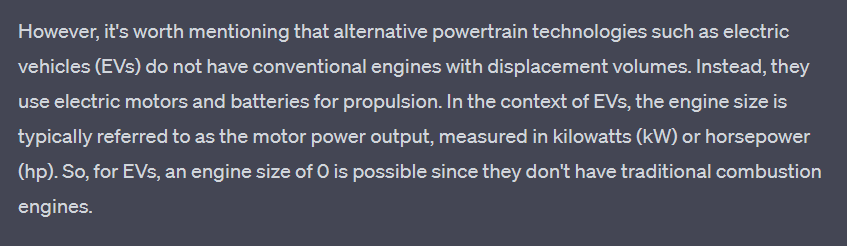

In [143]:
Image('enginesize.png')

## Data Exploration with visualisation

In [144]:
df.transmission.value_counts()

Manual       42472
Semi-Auto    15191
Automatic    13926
Other            4
Name: transmission, dtype: int64

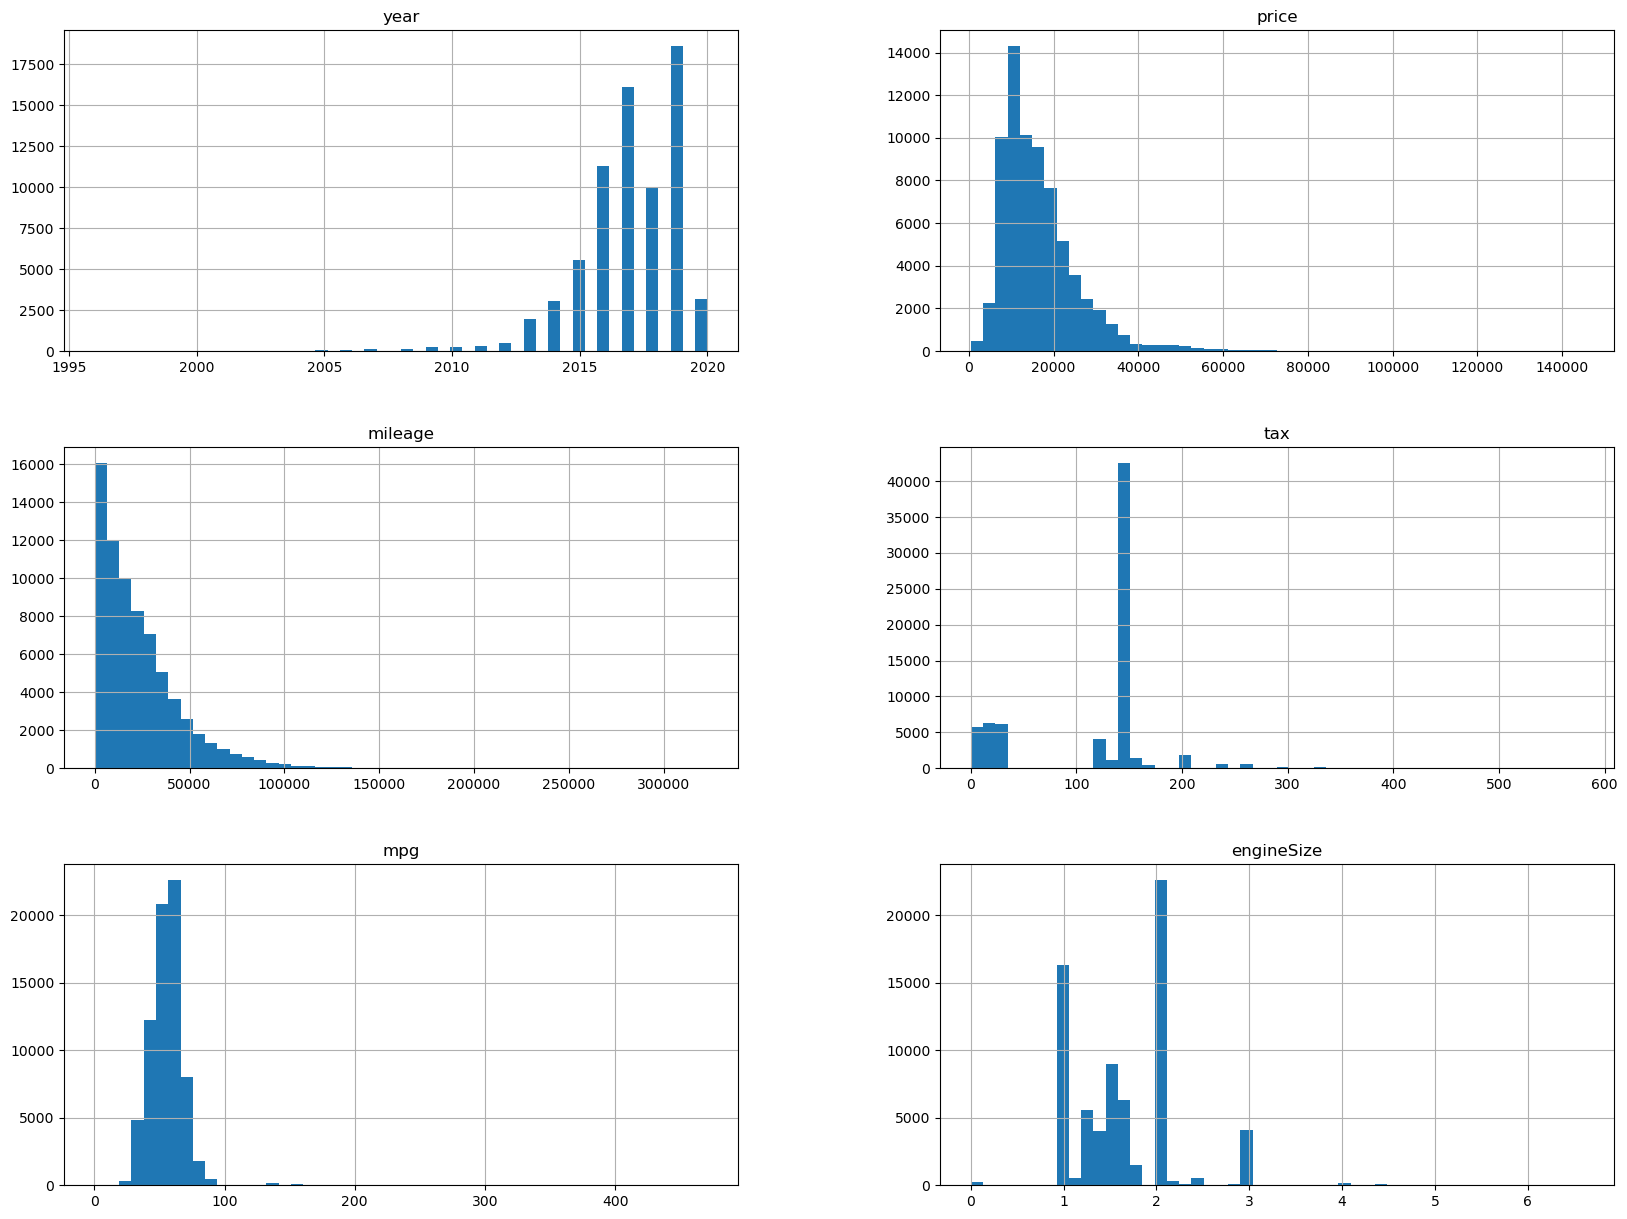

In [145]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [146]:
df.corrwith(df.price).abs().sort_values(ascending=False)

price         1.000000
engineSize    0.629810
year          0.519217
mileage       0.426230
tax           0.352663
mpg           0.332409
dtype: float64

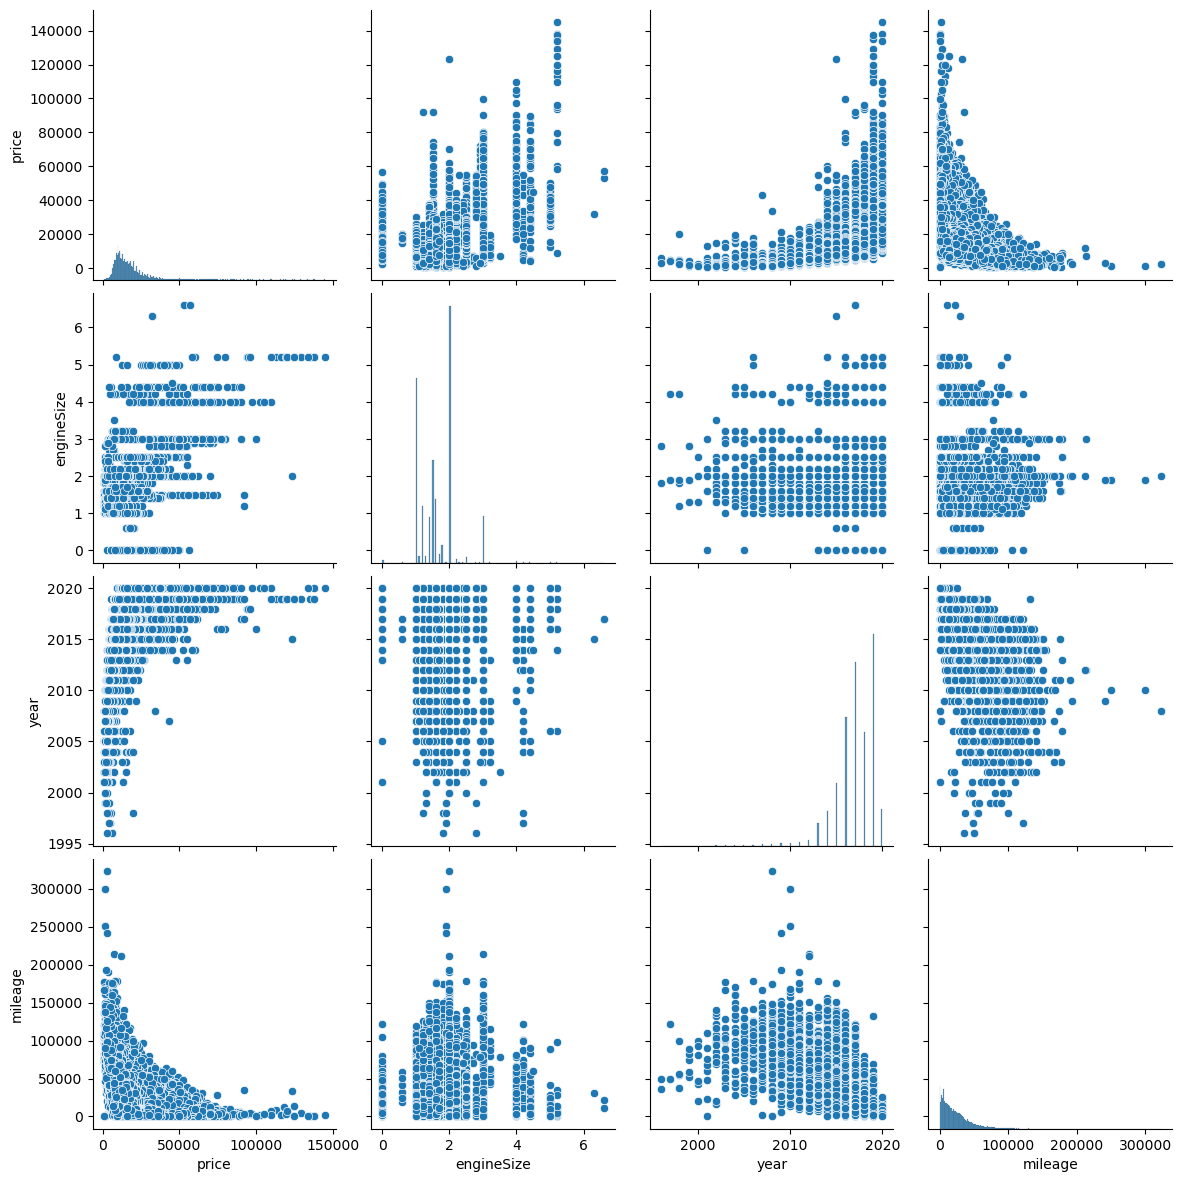

In [147]:
cols=['price','engineSize','year','mileage']
sns.pairplot(df[cols],height=3)
plt.show()

Additional Columns may help us to find more correlated values

In [148]:
df1=df.copy()
df1['mileage_mpg_ratio']=df1.mileage/df1.mpg
df1['price_mileage_ratio']=df1.price/df1.mileage
df1['mpg_engineSize_ratio']=df1.mpg/df1.engineSize

df1.corrwith(df1.price).abs().sort_values(ascending=False)

price                   1.000000
engineSize              0.629810
year                    0.519217
mileage                 0.426230
tax                     0.352663
mileage_mpg_ratio       0.336062
mpg                     0.332409
price_mileage_ratio     0.142079
mpg_engineSize_ratio         NaN
dtype: float64

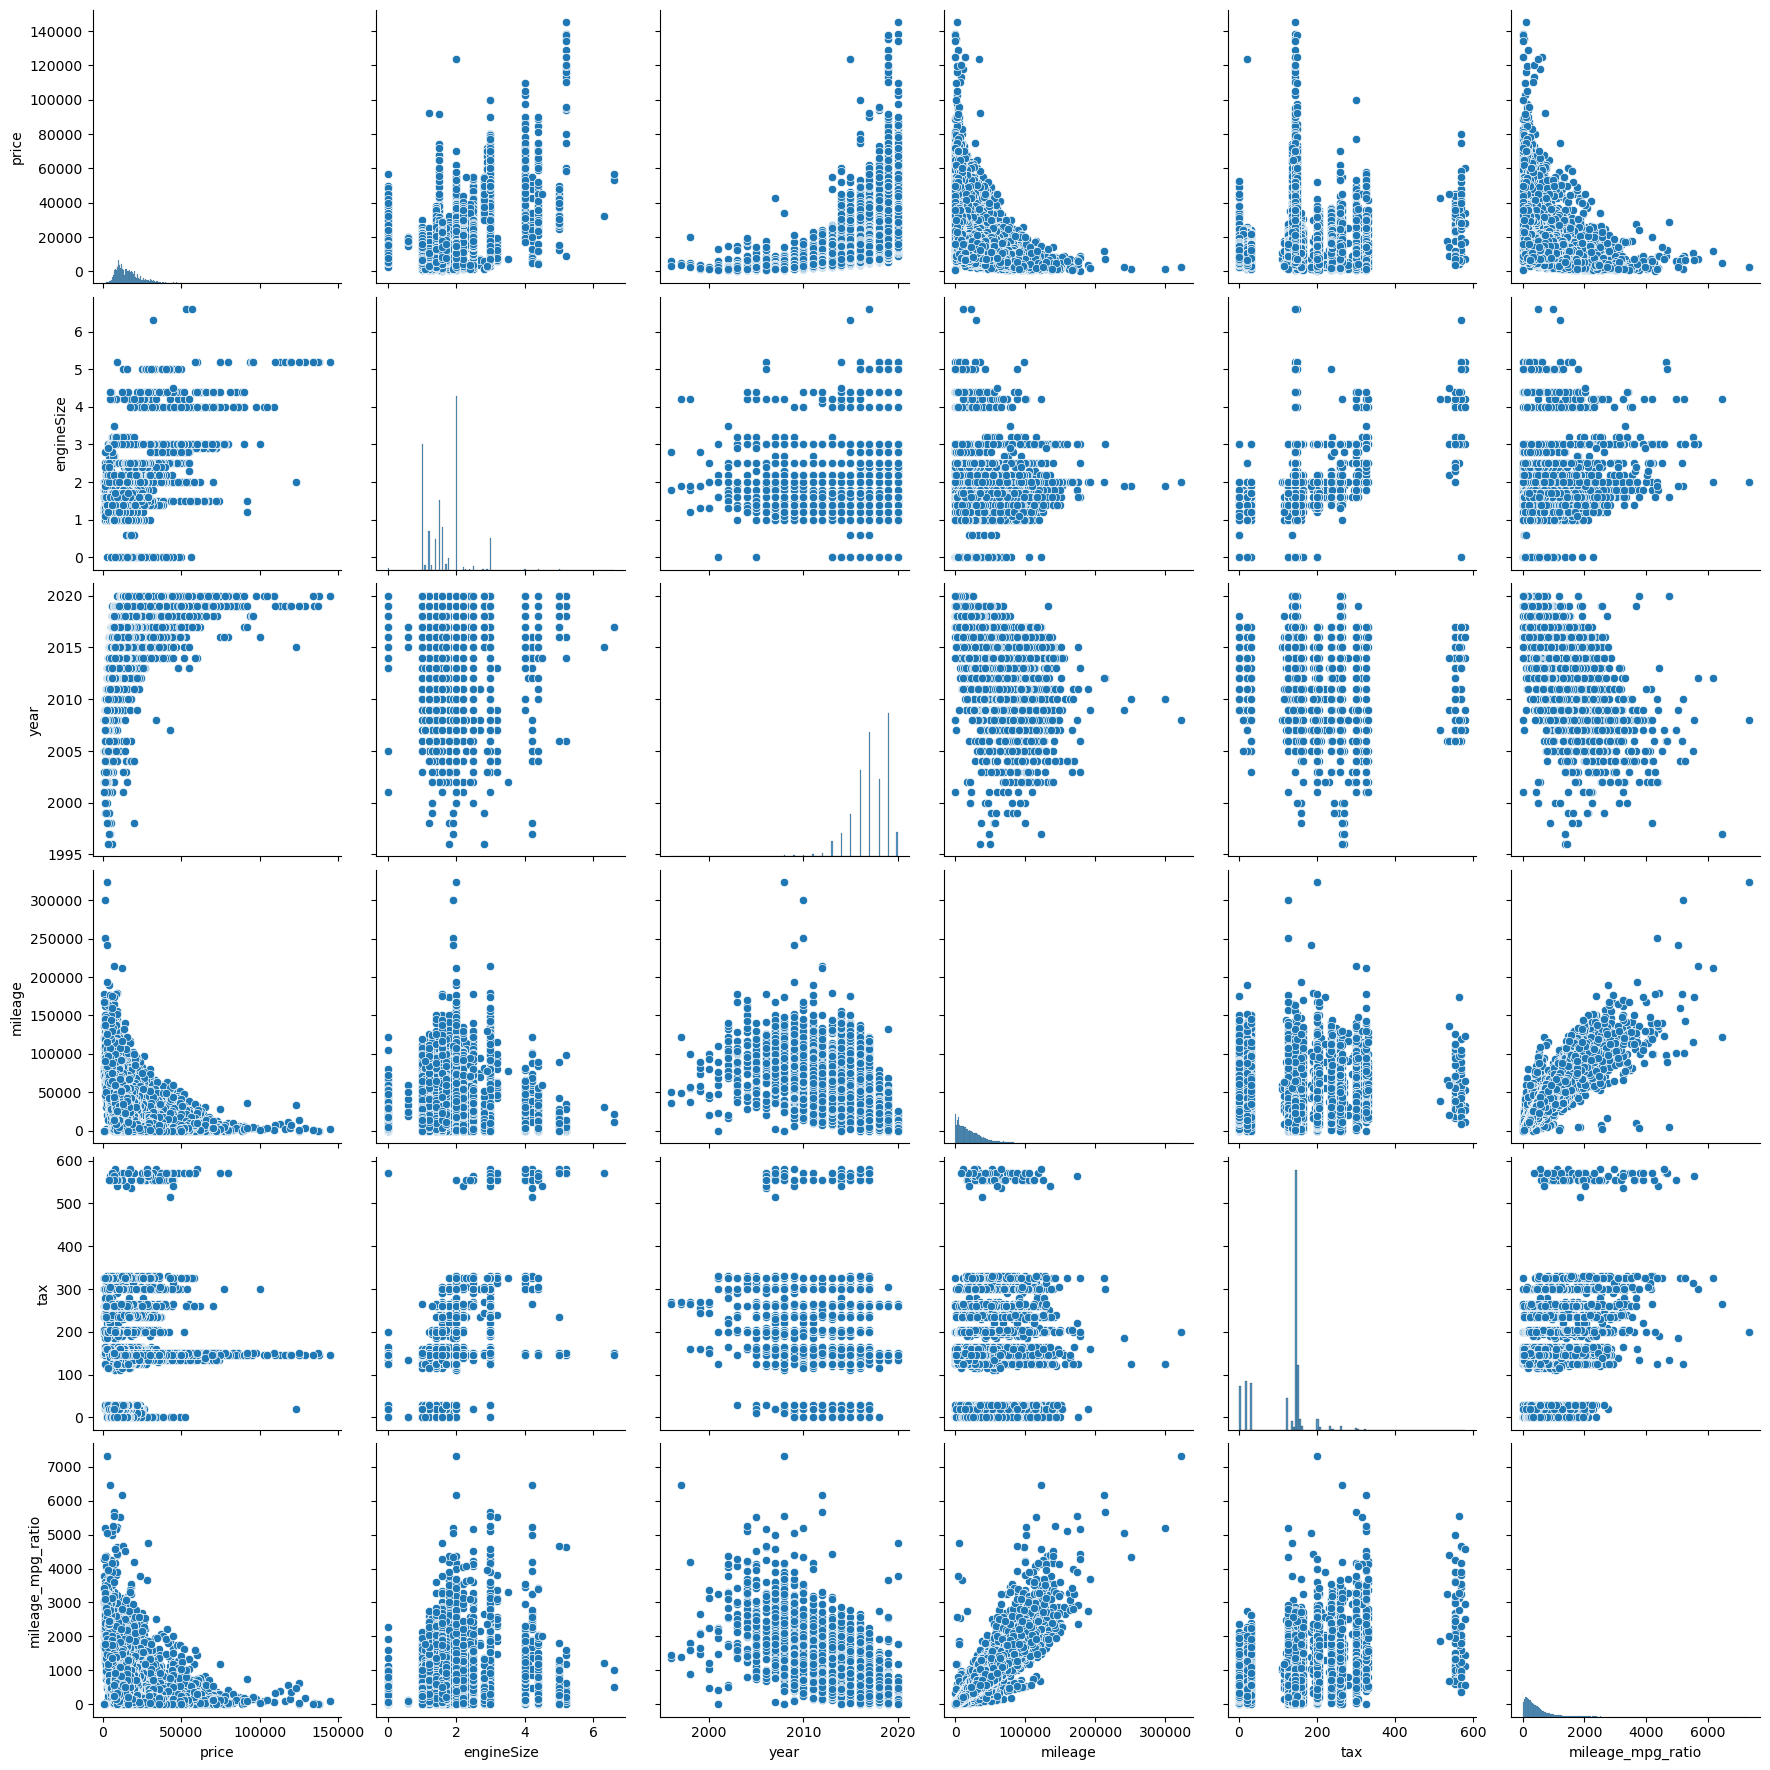

In [149]:
cols=['price','engineSize','year','mileage','tax','mileage_mpg_ratio']
sns.pairplot(df1[cols],height=3)
plt.show()

# Preprocessing for ML

In [150]:
X=df.drop(['price','model','Make'],axis=1)
y=df['price']
X_num=X.drop(['transmission','fuelType'],axis=1)

In [151]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=23)


Let's make Transformer

In [152]:
year_ix,mile_ix,mpg_ix,engine_ix=0,1,3,4
now=2021
class AttribAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_mpg_engine_ratio=True):
        self.add_mpg_engine_ratio=add_mpg_engine_ratio
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        mile_year_ratio=X[:,mile_ix]/(now-X[:,year_ix])
        mile_mpg_ratio=X[:,mile_ix]/X[:,mpg_ix]
        if self.add_mpg_engine_ratio:
            mpg_engine_ratio=X[:,engine_ix]/X[:,mpg_ix]
            return np.c_[X,mile_year_ratio,mile_mpg_ratio,mpg_engine_ratio]
        else:
            return np.c_[X,mile_year_ratio,mile_mpg_ratio]
        
attribs=AttribAdder()
x=attribs.transform(X_num.values)

In [153]:
pipe_num=Pipeline([
        ('imputer',SimpleImputer(strategy='median')),
        ('attribs',AttribAdder(add_mpg_engine_ratio=False)),
        ('standard',StandardScaler())])
nums=list(X_num)
cats=['transmission','fuelType']    
pipe_full=ColumnTransformer([
        ('numbers',pipe_num,nums),
        ('categories',OrdinalEncoder(),cats)])    

X_train_prepared=pipe_full.fit_transform(train_X)
X_test_prepared=pipe_full.fit_transform(test_X)

# Machine Learning

In [154]:
LR_model=LinearRegression()
LR_model.fit(X_train_prepared,train_y)
predict_LR=LR_model.predict(X_test_prepared)

In [155]:
class Evaluation:
    def __init__(self,y_value,predicted_value):
        self.y_value=y_value
        self.predicted_value=predicted_value
    def evol(self):
        MAE=mae(self.y_value,self.predicted_value)
        RMSE=np.sqrt(mse(self.y_value,self.predicted_value))
        r2=r2_score(self.y_value,self.predicted_value)*100    
        return [MAE,RMSE,r2]
    def get_evol(self):
        evols=self.evol()
        metrics=['MAE','RMSE','R2']
        i=0
        for n in evols:
            print(f"{metrics[i]}: {n}\n")
            i+=1

In [163]:
evo_LR=Evaluation(test_y,predict_LR)
LR_evol=evo_LR.evol()
evo.get_evol()

MAE: 3155.1977958433513

RMSE: 4773.921389654026

R2: 72.9407532210843



In [164]:
RF_model=RandomForestRegressor()
RF_model.fit(X_train_prepared,train_y)
predict_RF=RF_model.predict(X_test_prepared)
evo_RF=Evaluation(test_y,predict_RF)
RF_evol=evo_RF.evol()
evo_RF.get_evol()

C:\Users\OneComputers\AppData\Local\Temp\ipykernel_4156\1420562040.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(X_train_prepared,train_y)


MAE: 2219.412111689335

RMSE: 3478.32652920217

R2: 85.63499190874872



In [166]:
tree_model=DecisionTreeRegressor()
tree_model.fit(X_train_prepared,train_y)
predict_tree=tree_model.predict(X_test_prepared)
evo_tree=Evaluation(test_y,predict_tree)
tree_evol=evo_tree.evol()
evo_tree.get_evol()

MAE: 2905.5037351304795

RMSE: 4658.958117781392

R2: 74.22831649056047



In [159]:
X_prepared=pipe_full.fit_transform(X)
scores=cross_val_score(estimator=LR_model,X=X_prepared,y=y,scoring='neg_mean_squared_error',cv=5)

Simple Linear Regression (a column with a large dependency is used)

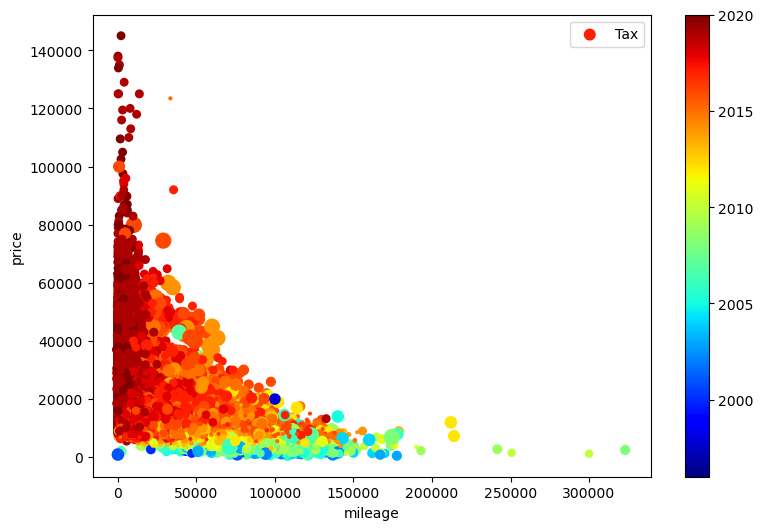

In [208]:
X,y=(df[['mileage']].values,df[['price']].values)
X=X/max(X)
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=23)
LR_simple=LinearRegression()
LR_simple.fit(train_X,train_y)
predict_simple=LR_simple.predict(test_X)

evol_simple=Evaluation(test_y,predict_simple)
Simple_evol=evol_simple.evol()
beta1=LR_simple.coef_[0][0] 
beta0=LR_simple.intercept_[0]

df.plot(kind='scatter',
        x='mileage',
        y='price',
        s=df['tax']/5,
        label='Tax',
        c=df['year'],
        cmap='jet',
        colorbar=True,
        figsize=(9,6)
        )
plt.show()

# Overall Conclusion

In [193]:
data_evo={'LR':LR_evol,
          'RF':RF_evol,
          'Tree':tree_evol}
metrics=pd.DataFrame(data_evo,index=['MAE','RMSE','R2']).T
metrics.reset_index(inplace=True)
metrics=pd.melt(metrics,id_vars=['index'],value_vars=['MAE','RMSE','R2'])

In [196]:
metrics.head()

,index,variable,value
0,LR,MAE,3155.197796
1,RF,MAE,2219.412112
2,Tree,MAE,2905.503735
3,LR,RMSE,4773.921390
4,RF,RMSE,3478.326529


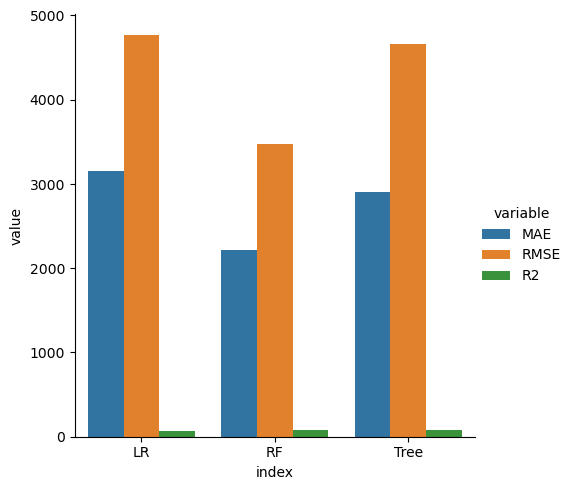

In [207]:
sns.catplot(data=metrics,kind='bar',x='index',y='value',hue='variable')
plt.show()

In [218]:
filenames=['Linear_Regression_model.pkl','Random_Forest_model.pkl','Decision_Tree_model.pkl']
models=[LR_model,RF_model,tree_model]
i=0
for name in filenames:
    with open(name,'wb') as file:
        pickle.dump(models[i],file)
        i+=1